# Interactions in adult intestine

In [1]:
import os
import pandas as pd
import numpy as np
import anndata as ann

import spatialdm as sdm
from spatialdm.datasets import dataset
import spatialdm.plottings as pl
print("SpatailDM version: %s" %sdm.__version__)

SpatailDM version: 0.0.2


The intestine dataset from Corbett, et al. was publicly available on STAR-FINDer, from which we obtained raw counts and spatial coordinates, and log-transformed to normalize on the spot-level. Rawcounts (.raw), logcounts (.X), cell types (.obs), and spatial coordinates (.obsm['spatial']) have been included in the corresponding anndata object which can be loaded directly in SpatialDM Python package.

<div class="alert alert-info">

**Note**
    
We have demonstrated the cross-replicate consistency in the differential analyses notebook, and here would like to zoom into an adult colon sample (with IBD or colon cancer, A1)
    
</div>  

In [2]:
A1_adata = dataset.A1()
log = pd.DataFrame(A1_adata.X, index=A1_adata.obs_names, columns=A1_adata.var_names)
raw = pd.DataFrame(A1_adata.raw.X, index=A1_adata.obs_names, columns=A1_adata.var_names)

In [3]:
A1 = sdm.SpatialDM(log, raw, A1_adata.obsm['spatial'])

In [4]:
A1.weight_matrix(l=75, cutoff=0.2, single_cell=False) # weight_matrix by rbf kernel

<div class="alert alert-info">

**Note**
Considering the scale of the spatial coordinates and spot-spot distance of 100 micrometers, l will be set to 75 here.\
Usually we need to run `weight_matrix` and the following plotting iteratively to optimize parameter `l` and `cutoff` \
Alternative to the cutoff parameter, we can set n_neighbors to around 8 to restrain the range of CCC.
    
</div>  

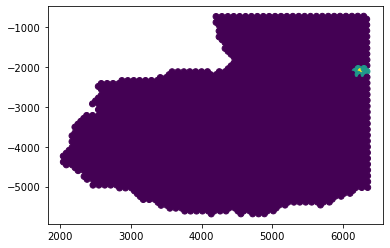

In [5]:
import matplotlib.pyplot as plt
plt.scatter(A1.spatialcoord.x, A1.spatialcoord.y, c=A1.rbf_d[500])

Filter sparse LR with fewer than 10 expressed spots.

In [6]:
A1.extract_lr('human', min_cell=10)      # find overlapping LRs from CellChatDB

Select significantly interacting pairs from the database using `z-score` method (or `both` here for the consistency analysis at the end)

In [7]:
A1.spatialdm_global(1000, select_num=None, method='both',nproc=1)     # global Moran selection, 
A1.sig_pairs(method='z-score', fdr=True, threshold=0.1)     # select significant pairs

100%|██████████| 1000/1000 [00:23<00:00, 43.03it/s]


In [8]:
A1.global_res.selected.sum()

383

We used fdr corrected global p-values and a threshold FDR < 0.1 (default) to determine which pairs to be included in the following local identification steps. There are 383 pairs being selected in this data.

In [9]:
A1.spatialdm_local(n_perm=1000, method='both', select_num=None, nproc=1)     # local spot selection

100%|██████████| 1000/1000 [00:18<00:00, 54.82it/s]


Select significant spots with a p-value cutoff of 0.1

In [10]:
A1.sig_spots(method='z-score', fdr=False, threshold=0.1)     # significant local spots

Visualize all pairs in a scatter plot and highlight target pairs

In [11]:
EGF_ind = A1.geneInter.loc[A1.geneInter.pathway_name=='EGF'].index.intersection(A1.global_res.index[A1.global_res.selected])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


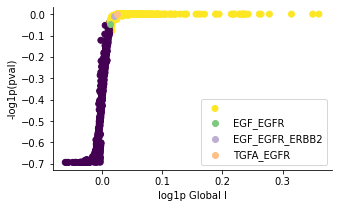

In [12]:
pl.global_plot(A1, pairs=EGF_ind.to_list()[:3], figsize=(5,3))

## Spatial Clustering of Local Spots

[SpatialDE](https://github.com/Teichlab/SpatialDE) allows clustering of spatially auto-correlated genes. Here, we repurposed SpatialDE to identify spatially auto-correlated interactions by using binary local selection status as input.

In [13]:
import NaiveDE
import SpatialDE

In [14]:
# SpatialDE code
bin_spots = A1.selected_spots.astype(int)[A1.n_spots>=10]

results = SpatialDE.run(A1.spatialcoord, bin_spots.transpose())

/home/yoyo/miniconda2/envs/CC/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/home/yoyo/miniconda2/envs/CC/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

Filter out sparse interactions with fewer than 10 identified interacting spots (91 pairs). Cluster into 4 patterns.

In [15]:
histology_results, patterns = SpatialDE.aeh.spatial_patterns(A1.spatialcoord, bin_spots.transpose(),
                                                             results, C=4, l=300,
                                                             verbosity=1)

iter 0, ELBO: -7.24e+11
iter 1, ELBO: -3.62e+11, delta_ELBO: 3.62e+11
iter 2, ELBO: -3.62e+11, delta_ELBO: 1.14e+05
iter 3, ELBO: -3.62e+11, delta_ELBO: 7.74e+03
iter 4, ELBO: -3.62e+11, delta_ELBO: 2.10e+04
iter 5, ELBO: -3.62e+11, delta_ELBO: 5.17e+02
iter 6, ELBO: -3.62e+11, delta_ELBO: 9.60e+01
iter 7, ELBO: -3.62e+11, delta_ELBO: 2.88e+00
iter 8, ELBO: -3.62e+11, delta_ELBO: 1.08e+00
iter 9, ELBO: -3.62e+11, delta_ELBO: 3.54e-02
iter 10, ELBO: -3.62e+11, delta_ELBO: 1.83e-04
Converged on iter 10


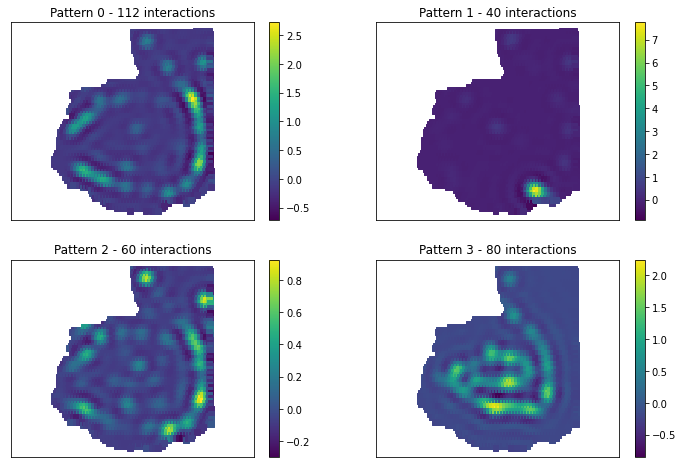

In [18]:
pdf_dir = '/home/yoyo/'

plt.figure(figsize=(12,8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.scatter(A1.spatialcoord['x'], A1.spatialcoord['y'], marker = 's',c=patterns[i], s=35);
    plt.axis('equal')
    pl.plt_util('Pattern {} - {} interactions'.format(i, histology_results.query('pattern == @i').shape[0] ))
#     plt.savefig(pdf_dir+'SpatialDE_patterns.pdf') #2 # new dfb

In [19]:
dic=dict()
for i in histology_results.sort_values('pattern').pattern.unique():
    dic['Pattern_{}'.format(i)]=histology_results.query('pattern == @i').sort_values('membership')['g'].values

In [20]:
sdm.compute_pathway(A1, dic=dic)

From cell type annotations in the original study, Pattern 3 is mostly cryp top colonocytes

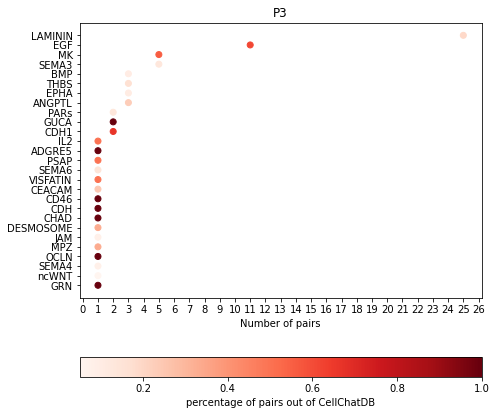

In [23]:
pl.dot_path(A1, 'P3', pdf=pdf_dir+'P3_pathways', figsize=(7,6))

## EGF interactions

Interestingly, EGF is enriched in Pattern ?. It will be helpful to breakdown each EGF pair and their LRI pattern.

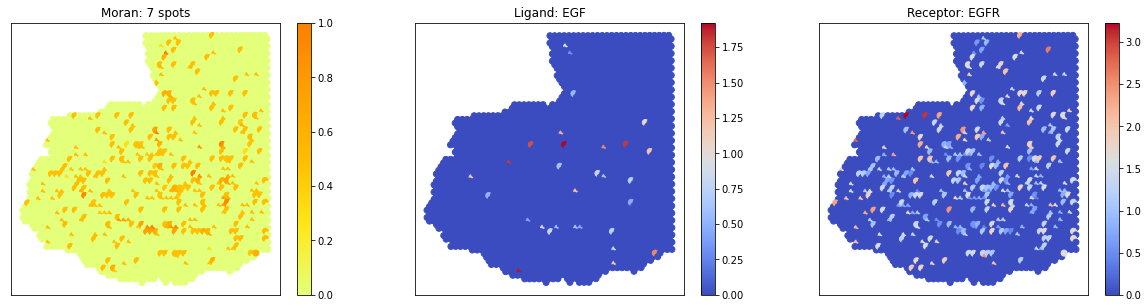

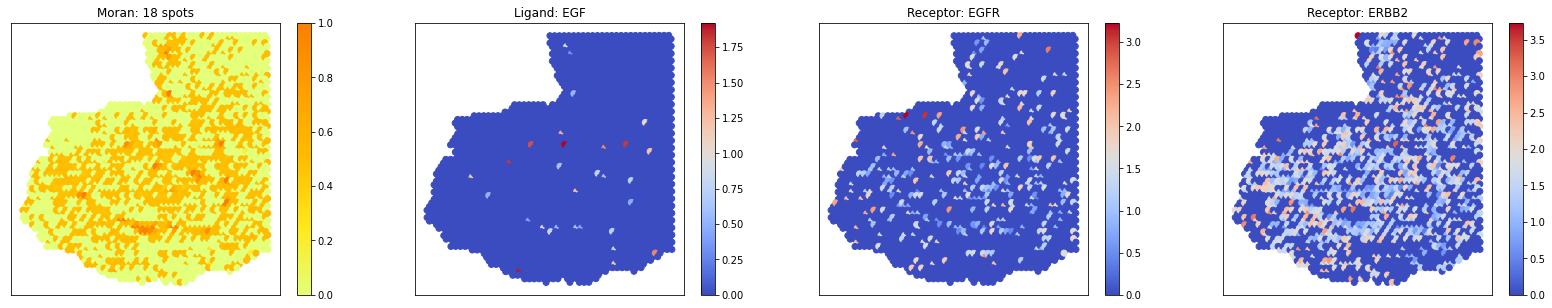

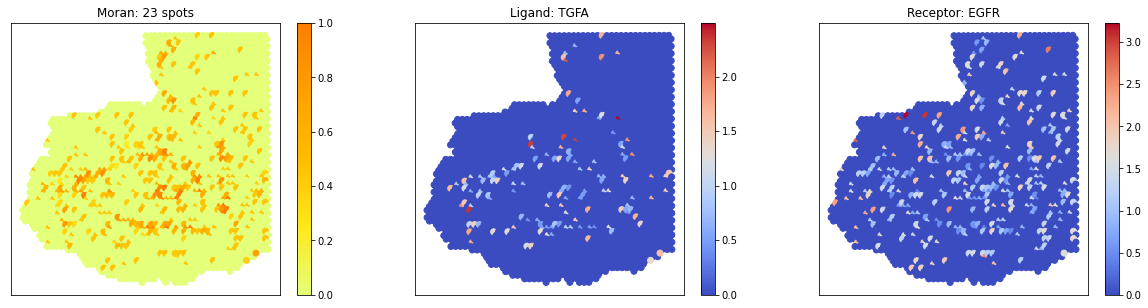

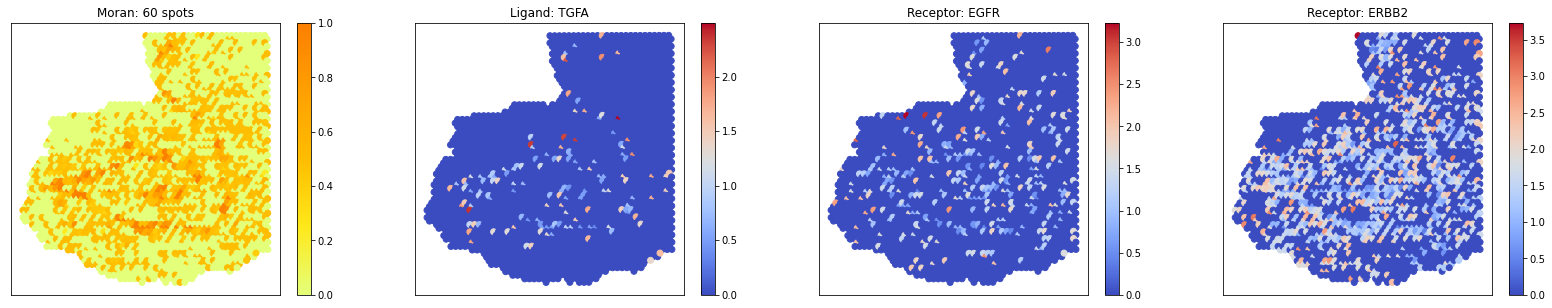

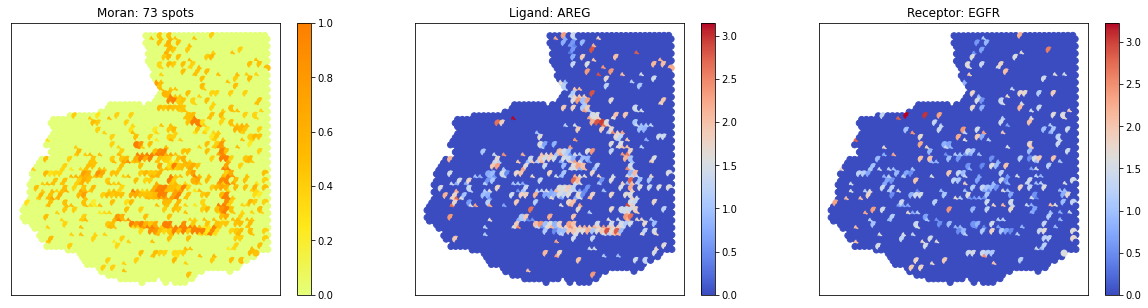

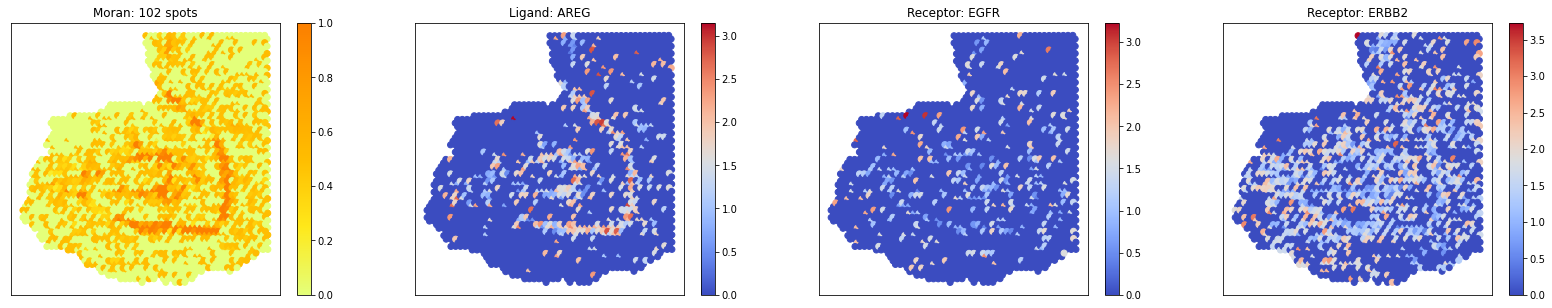

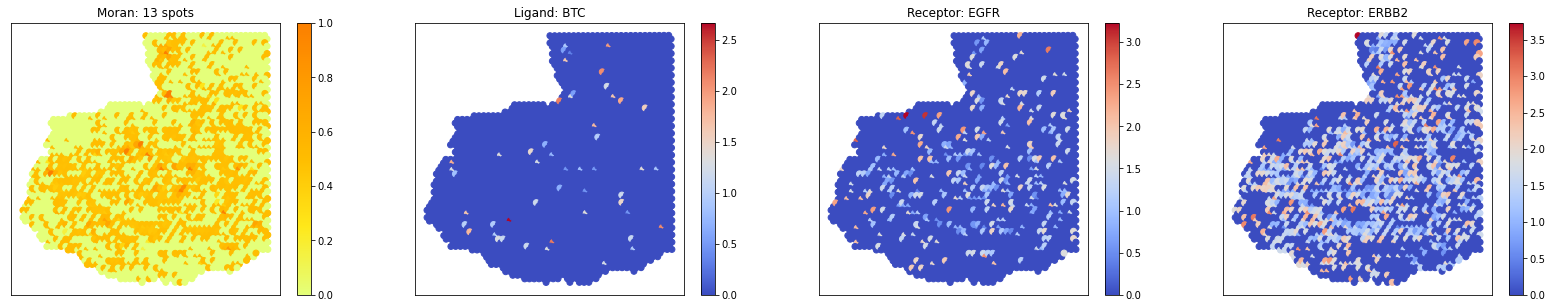

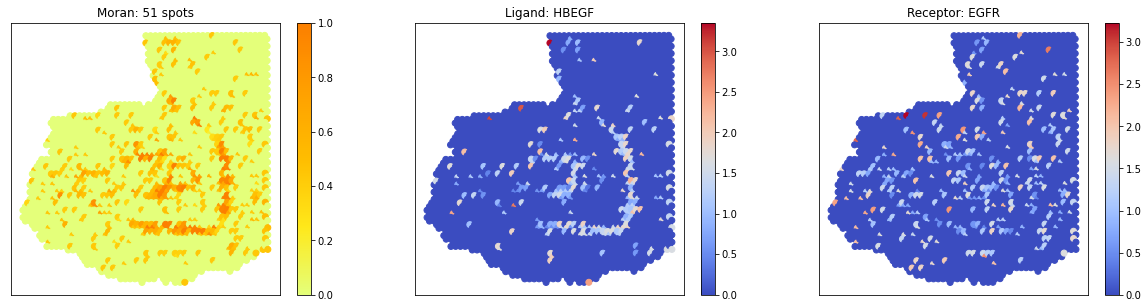

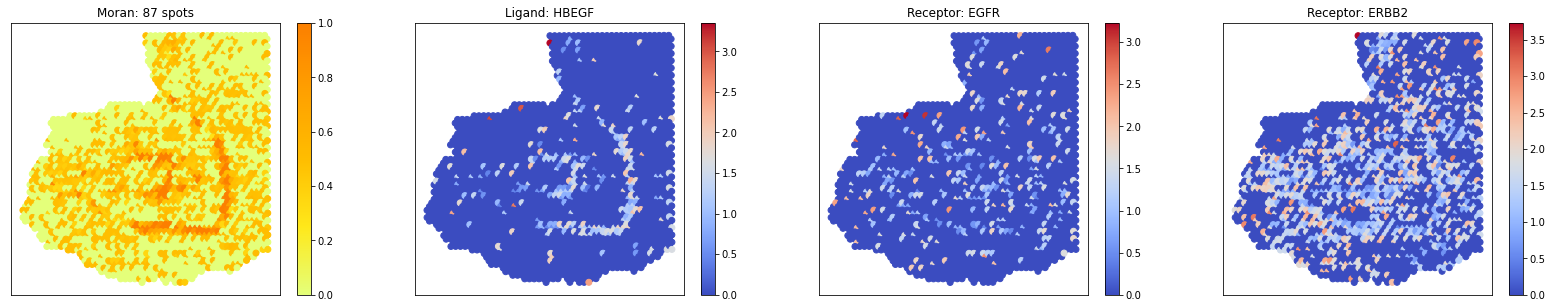

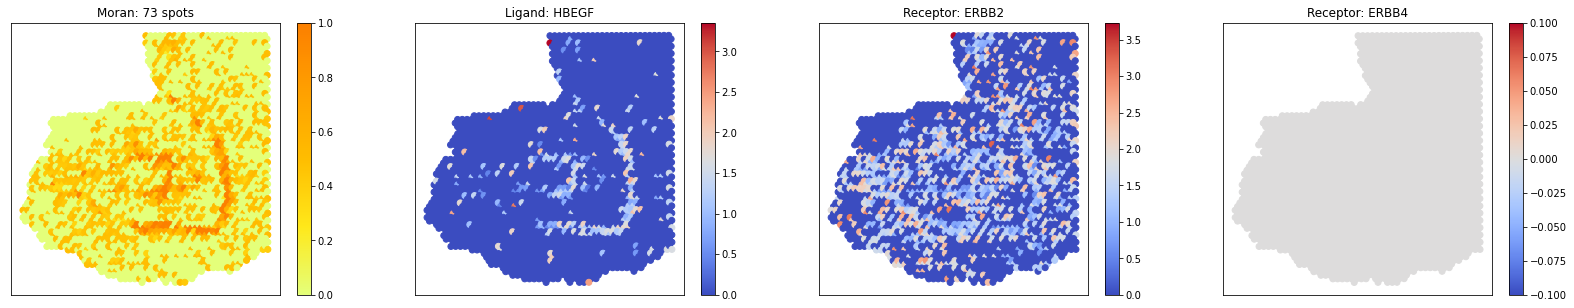

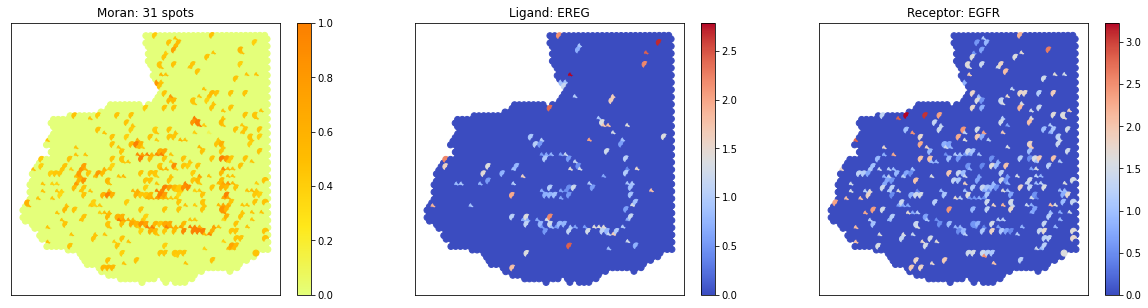

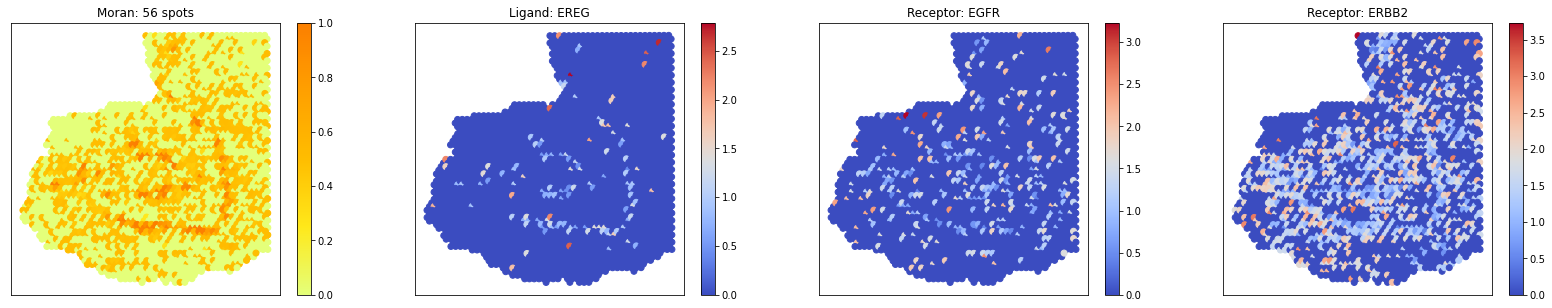

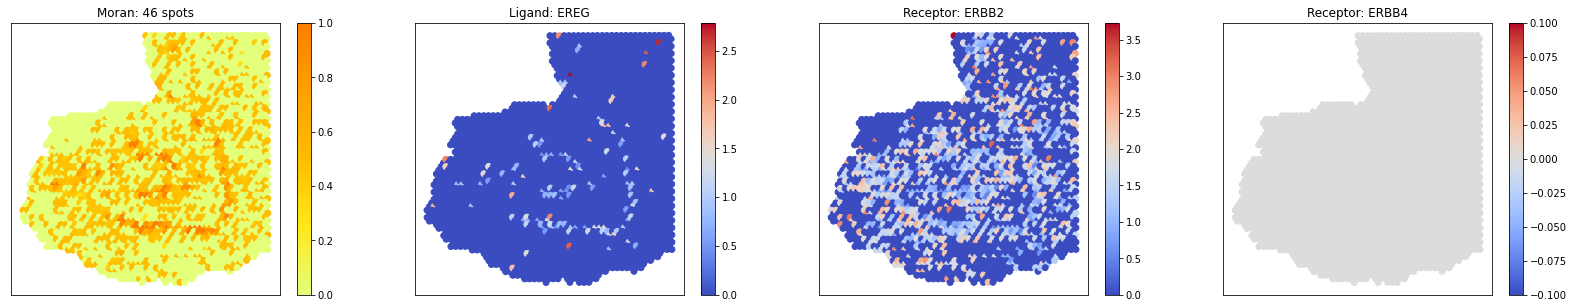

In [24]:
# visualize pattern 2 pairs
pl.plot_pairs(A1, EGF_ind, pdf=pdf_dir+'egf_pairs', cmap='Wistia')

We then examined the selection of local spots by checking if EGF upstream / downstream molecules are co-existent with selected spots

In [27]:
logcounts = A1.logcounts.copy()
logcounts = logcounts.loc[:, ['RALA','MAPK3','RALB']]
logcounts.loc[:,['Moran_selected']] = (A1.local_z_p.loc['AREG_EGFR_ERBB2']<0.1).values  # AREG as an example

In [35]:
EGF_df = pd.DataFrame(np.vstack((logcounts.loc[:,['RALA','Moran_selected']].values,
 logcounts.loc[:,['MAPK3','Moran_selected']].values,
    logcounts.loc[:,['RALB','Moran_selected']].values)), columns=['logcounts', 'Moran_selected'])
n_spots=A1.spatialcoord.shape[0]
EGF_df.loc[:,'gene'] = ['RALA']* n_spots+['MAPK3']*n_spots+['RALB']*n_spots
EGF_df.gene=EGF_df.gene.astype('category')
EGF_df.logcounts=EGF_df.logcounts.astype(np.float64)

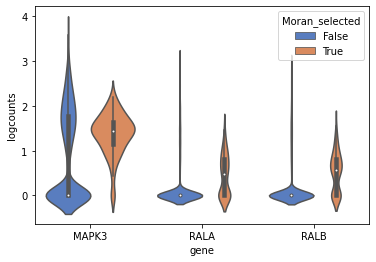

In [36]:
import seaborn as sns
ax = sns.violinplot(x="gene", y="logcounts", hue="Moran_selected",
                     data=EGF_df, palette="muted", split=False)
plt.savefig(pdf_dir+'egf_downstream.pdf')

EGF upstream / downstream molecules correlate with selected spots, validating Moran selection of local spots.

## Consistency between permutation and z-score approaches

/tmp/ipykernel_91931/4190360524.py:2: RuntimeWarning: divide by zero encountered in log10
  x = -np.log10(A1.global_res.z_pval.values)


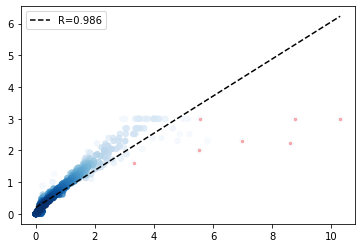

In [38]:
# 100 permutation here
x = -np.log10(A1.global_res.z_pval.values)
y = -np.log10(A1.global_res.perm_pval)
x = x[~np.isinf(y)]  # x = np.where(x>3, 3, x)
y = y[~np.isinf(y)]  # y = np.where(np.isinf(y), 3, y)
pl.corr_plot(x, y, method='spearman')

Text(0.5, 1.0, 'Correlation of number of selected local spots (Permutation vs. z-score)')

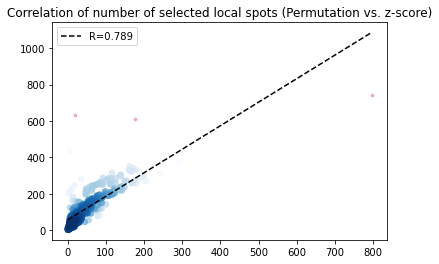

In [39]:
x=(A1.local_z_p<0.1).sum(1).values
y=(A1.local_perm_p<0.1).sum(1).values
pl.corr_plot(x, y, method='pearson')
plt.title('Correlation of number of selected local spots (Permutation vs. z-score)')